In [103]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [104]:
#Import the finite market model functionality from the PortfolioBase notebook
%pip install nbformat
%run PortfolioBase.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import numpy as np
import pandas as pd
import csv
from contextlib import closing
import csv
from codecs import iterdecode

from sklearn.cluster import AgglomerativeClustering
from scipy.stats import wasserstein_distance


import matplotlib.pyplot as plt

In [117]:

file = open("FTSE100.tickers")
iter = csv.reader(file, delimiter='\n')

tickers = []
train_stocks = {}
validate_stocks = {}
test_stocks = {}

for ticker in iter:
    tickers=tickers+[ticker[0].split(".")[0]]

for tick in tickers:
    stockData = pd.read_csv(f"HistoricPrices/{tick}.csv", header = 0, names=("Day", "Price"))
    train_stocks[tick], further_stocks = np.split(stockData, [int(.80 *len(stockData))])
    validate_stocks[tick], test_stocks[tick] = np.split(further_stocks, [int(.50 *len(further_stocks))])

#Split such that we are considering intervals of time rather than random times 
print(test_stocks)
print(len(validate_stocks["BA"]))
print(len(test_stocks["BA"]))


C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return b

{'III':        Day        Price
1134  1134  1981.463257
1135  1135  1997.459106
1136  1136  1990.960815
1137  1137  2000.458252
1138  1138  2017.453613
...    ...          ...
1256  1256  2189.739746
1257  1257  2203.738281
1258  1258  2230.734863
1259  1259  2232.000000
1260  1260  2248.000000

[127 rows x 2 columns], 'ADM':        Day        Price
1134  1134  2308.448975
1135  1135  2280.600342
1136  1136  2281.594971
1137  1137  2315.411133
1138  1138  2197.054443
...    ...          ...
1256  1256  2709.000000
1257  1257  2709.000000
1258  1258  2703.000000
1259  1259  2701.000000
1260  1260  2706.000000

[127 rows x 2 columns], 'AAF':        Day       Price
1008  1008  109.315186
1009  1009  108.332138
1010  1010  105.972824
1011  1011  106.562653
1012  1012  105.874512
...    ...         ...
1115  1115  113.099998
1116  1116  112.400002
1117  1117  111.800003
1118  1118  109.500000
1119  1119  111.500000

[112 rows x 2 columns], 'AAL':        Day        Price
1134  1134  2402.880

C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return b

In [107]:
def estimateClassProbsFromSample(preds,classes):
    probs = []
    for i in range(classes):
        probs.append(np.count_nonzero(preds == float(i))/len(preds))
    return probs

#Use the mean element as a representitive of the cluster (could have also have used the median)
def calculateCentralClassElement(x, preds, classes):
    sizes = {x:0 for x in range(classes)}
    cumulative = {x:0 for x in range(classes)}
    for i in range(len(x)):
        assignedClass = int(preds[i])
        sizes[assignedClass] += 1
        cumulative[assignedClass] += x[i]
    return [cumulative[i]/sizes[i] for i in range(classes)]

def calculateChange(data, type):
    if type == "percentage":
        return (data["Price"]/data["Price"].shift()).dropna()
    elif type == "abs":
        return data.diff().dropna()["Price"]
    else:
        raise("Type is not supported")

In [108]:
def naiveFitMultinomialStock(stocksData, ticker : str, classes : int, linkage = "ward"):

    #data = stocksData[ticker].diff().dropna()["Price"].to_numpy()
    data = calculateChange(stocksData[ticker], "percentage").to_numpy()[1:]
    

    clust = AgglomerativeClustering(classes ,linkage=linkage)
    clust.fit(data.reshape(-1, 1))
    
    preds = clust.fit_predict(data.reshape(-1, 1))

    meanJumps = calculateCentralClassElement(data,preds,classes)
    jumpProbs = estimateClassProbsFromSample(preds,classes)

    initial = stocksData[ticker].dropna()["Price"][1]
    model = MultinomialStock(f"{ticker} {str(classes)}-jump",initial,meanJumps, jumpProbs)
    return model

In [109]:
def plotStockPrice(stocksData, ticker, jumpClasses = 10, realisations = 5):
    stock = naiveFitMultinomialStock(stocksData,ticker,jumpClasses)
    runs = []
    for h in range(realisations):
        values = []
        for i in range(len(stocksData[ticker])):
            values.append(stock.value)
            stock.evolve()
        stock.reset()
        runs.append(values)

    for values in runs:
        plt.plot(values)

    plt.title(f"The price over time of {str(realisations)} multinomial({str(jumpClasses)}-class) model realisations for {stock}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()
    for values in runs:
        plt.plot(values - stocksData[ticker]["Price"])

    plt.title(f"The difference in price between the fitted model and actual {stock} stock price")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

In [110]:
# Accessed from https://scikit-learn.org/stable/_downloads/4cb9ca0dda94124c7cb99dcaae983dab/plot_agglomerative_dendrogram.py
# Authors: Mathew Kallada, Andreas Mueller
# License: BSD 3 clause
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [118]:
def plotJumpClustering(stocksData, ticker, jumpClasses = 10, linkage = "ward"):
    data = calculateChange(stocksData[ticker], "percentage").to_numpy()[1:]
    clust = AgglomerativeClustering(jumpClasses,linkage=linkage)
    reshapedData = data.reshape(-1, 1)
    clust.fit(reshapedData)

    preds = clust.fit_predict(reshapedData)

    plt.scatter(preds, data)
    plt.xlabel("Clustering")
    plt.ylabel("Price")
    plt.title("The ....")
    plt.show()

    fullClustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    fullClustering.fit(reshapedData)
    plot_dendrogram(fullClustering, truncate_mode="level", p=7)
    plt.title(f"A dendrogram to show the formation of clusters for {ticker}")
    plt.show()

{'III':        Day        Price
0        0   692.629211
1        1   682.945618
2        2   648.118774
3        3   650.327393
4        4   662.898987
...    ...          ...
1003  1003  1333.733643
1004  1004  1333.242432
1005  1005  1319.487549
1006  1006  1317.031250
1007  1007  1324.891113

[1008 rows x 2 columns], 'ADM':        Day        Price
0        0  1807.131104
1        1  1783.116089
2        2  1710.642212
3        3  1721.362915
4        4  1711.499756
...    ...          ...
1003  1003  2082.290527
1004  1004  2103.044189
1005  1005  2010.146484
1006  1006  2003.228638
1007  1007  2002.240356

[1008 rows x 2 columns], 'AAF':      Day       Price
0      0   54.126019
1      1   56.680637
2      2   57.478962
3      3   57.558784
4      4   57.798290
..   ...         ...
891  891  109.476608
892  892  105.652100
893  893  106.034546
894  894  109.189766
895  895  113.109901

[896 rows x 2 columns], 'AAL':        Day        Price
0        0  1333.825806
1        1  1305.7

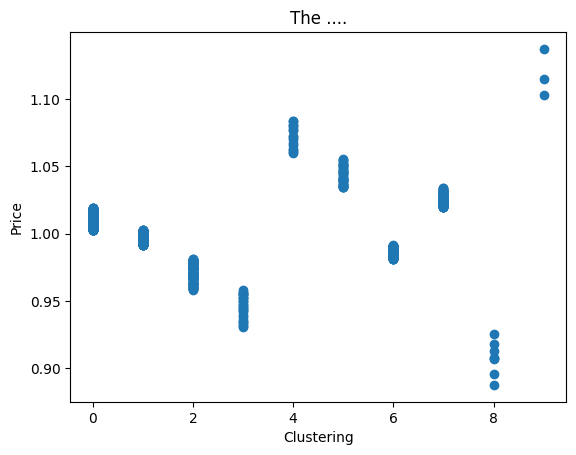

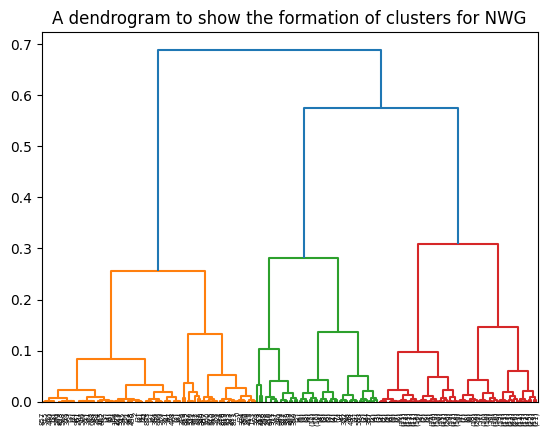

In [119]:
plotJumpClustering(train_stocks, "NWG")

In [142]:
ftse100 = []
for tick in tickers:
    ftse100.append(naiveFitMultinomialStock(train_stocks, tick, 6))

ftse100Market = Market(ftse100)
for i in range(len(stocks["NWG"])):
    ftse100Market.evolve()


ftse100_10jump = []
for tick in tickers:
    ftse100_10jump.append(naiveFitMultinomialStock(train_stocks, tick, 10))

ftse100_10jumpMarket = Market(ftse100_10jump)
for i in range(len(stocks["NWG"])):
    ftse100_10jumpMarket.evolve()


# Validation 

Select best hyperparameters for each stock model (cluster size, linkage).

Evaluate the Wasserstein distance and predict the most accurate stocks and least accurate stocks.

# Test

- Comparision of Wasserstein distances (model vs sample), rank order the stocks.

- Comparision of variances (100 runs, variance over each run)

- Comparision of market returns??

- Autocorrelation of sample (models at the momement have zero autocorrelation)

In [114]:
#for i in range(len(tickers)):
#    wd = someDist(np.array(ftse100Market.history)[:,i], stocks[tickers[i]]["Price"])

NameError: name 'someDist' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[-1.29078528e-01 -1.23209446e-01 -1.11443502e-01 -9.40276886e-02
 -8.64946612e-02 -8.53664916e-02 -7.53864614e-02 -7.16786729e-02
 -7.10070270e-02 -6.56429609e-02 -6.26721003e-02 -5.93153749e-02
 -5.74337145e-02 -5.55696165e-02 -5.44718075e-02 -5.25205703e-02
 -4.93275602e-02 -4.57676869e-02 -4.57396746e-02 -4.01998214e-02
 -3.98305504e-02 -3.76137321e-02 -3.72386210e-02 -3.71180351e-02
 -3.68204972e-02 -3.61542766e-02 -3.61016157e-02 -3.58161647e-02
 -3.49384182e-02 -3.04285813e-02 -2.98006610e-02 -2.77828964e-02
 -2.48732443e-02 -2.46761398e-02 -1.76361742e-02 -1.68458435e-02
 -1.49847522e-02 -1.47829304e-02 -1.27523619e-02 -1.14912411e-02
 -1.13063577e-02 -1.12971838e-02 -1.12519017e-02 -1.12279268

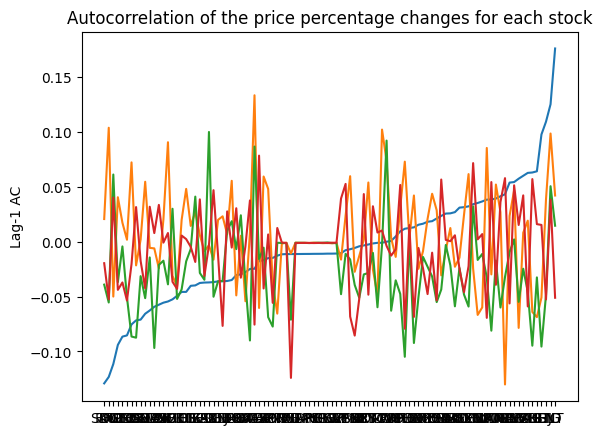

In [140]:
#Issues with scale??
acf = []

lags = 5
for i in range(len(tickers)):
    #realSample = stocks[tickers[i]]["Price"].diff().dropna()[1:]
    print(i)
    realSample = calculateChange(train_stocks[tickers[i]], "percentage")[1:]

    diffACF = []
    for h in range(1,lags):
        diffACF.append(realSample.autocorr(lag=h))
    acf.append([np.array(diffACF), tickers[i]])

def distSort(e):
    return float(e[0][0])

acf.sort(key=distSort)
sTickers = []
sDistances = []
sDist2 = []
for item in acf:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.title("Autocorrelation of the price percentage changes for each stock")
plt.ylabel("Lag-1 AC")
print(np.array(sDistances)[:,0])

for i in range(lags-1):
    plt.plot(sTickers, np.array(sDistances)[:,i])

print(sTickers)
print(sDistances)

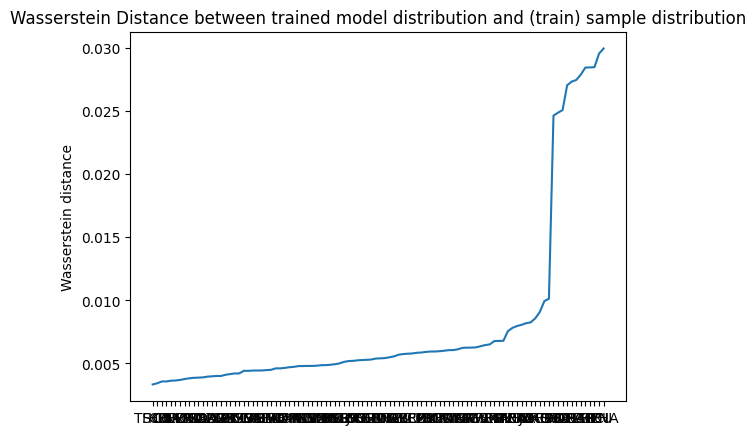

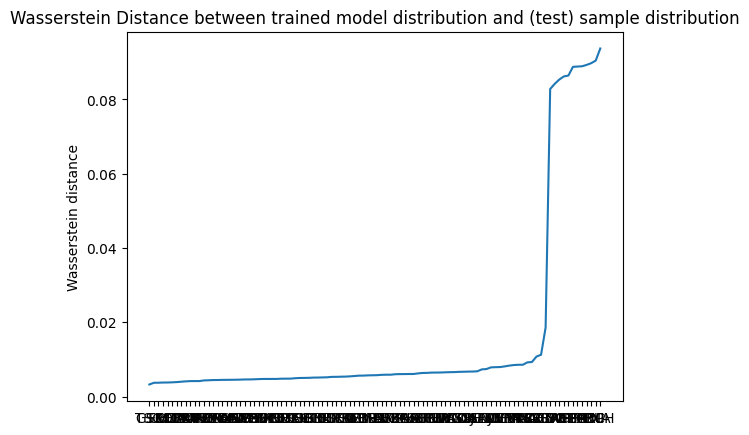

['GSK', 'TSCO', 'UU', 'FCIT', 'REL', 'VOD', 'HLMA', 'ULVR', 'RKT', 'BATS', 'AUTO', 'BNZL', 'IMB', 'AZN', 'PHNX', 'HWDN', 'DGE', 'RMV', 'SGRO', 'ADM', 'LAND', 'SPX', 'EXPN', 'SSE', 'ITRK', 'RS1', 'SBRY', 'DCC', 'MNDI', 'HSBA', 'BME', 'BKG', 'HLN', 'SGE', 'HIK', 'SDR', 'SN', 'CTEC', 'GLEN', 'IMI', 'UTG', 'BDEV', 'SKG', 'RIO', 'III', 'PSH', 'SMIN', 'CCH', 'FRES', 'SMDS', 'DPLM', 'AV', 'BEZ', 'LLOY', 'BT-A', 'BP', 'KGF', 'SMT', 'NXT', 'LSEG', 'ABF', 'SHEL', 'BRBY', 'CRDA', 'TW', 'NWG', 'IHG', 'RTO', 'PSON', 'STJ', 'INF', 'LGEN', 'AHT', 'AAL', 'STAN', 'EDV', 'JD', 'WTB', 'WEIR', 'ENT', 'FRAS', 'MKS', 'MNG', 'MRO', 'AAF', 'IAG', 'RR', 'OCDO', 'BA', 'NG', 'SVT', 'WPP', 'ANTO', 'CPG', 'FLTR', 'HL', 'BARC', 'PRU', 'CNA', 'DPH']
['TSCO', 'FCIT', 'HLN', 'GSK', 'REL', 'ULVR', 'BATS', 'HLMA', 'RKT', 'UU', 'CRDA', 'VOD', 'SGRO', 'AZN', 'BNZL', 'DGE', 'SPX', 'ITRK', 'DCC', 'RMV', 'HSBA', 'SGE', 'IMB', 'SSE', 'PSH', 'AUTO', 'BME', 'RTO', 'HWDN', 'ADM', 'EXPN', 'LAND', 'III', 'RS1', 'PHNX', 'MNDI', 'SN

In [143]:
#Issues with scale??
trainWd = []
testWd = []
for i in range(len(tickers)):
    stock = ftse100Market.assets[i]
    #realSample = np.array(stocks[tickers[i]]["Price"].diff().dropna()[1:])
    trainSample = calculateChange(train_stocks[tickers[i]], "percentage").to_numpy()[1:]
    testSample = calculateChange(test_stocks[tickers[i]], "percentage").to_numpy()[1:]
    trainWd.append([wasserstein_distance(u_values=stock.values, v_values=trainSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(trainSample))/len(trainSample)), tickers[i]])
    
    testWd.append([wasserstein_distance(u_values=stock.values, v_values=testSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(testSample))/len(testSample)), tickers[i]])

def distSort(e):
    return float(e[0])

trainWd.sort(key=distSort)
testWd.sort(key=distSort)
trainTickers = []
testTickers = []
trainDistances = []
testDistances = []

for item in trainWd:
    trainTickers.append(item[1])
    trainDistances.append(item[0])
for item in testWd:
    testTickers.append(item[1])
    testDistances.append(item[0])
    
plt.title("Wasserstein Distance between trained model distribution and (train) sample distribution")
plt.ylabel("Wasserstein distance")
plt.plot(trainTickers, trainDistances)
plt.show()

plt.title("Wasserstein Distance between trained model distribution and (test) sample distribution")
plt.ylabel("Wasserstein distance")
plt.plot(testTickers, testDistances)
plt.show()

print(testTickers)
print(trainTickers)

print(testDistances)
print(trainDistances)

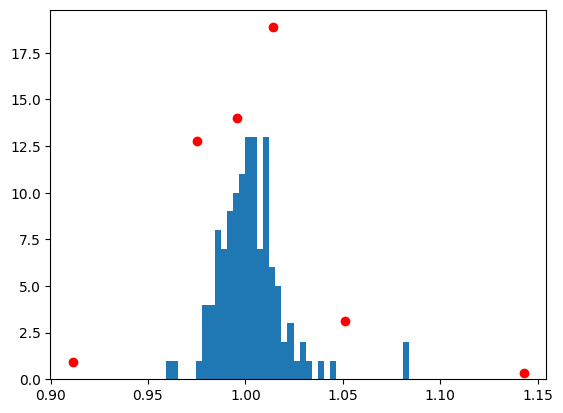

In [172]:
plt.hist(calculateChange(test_stocks["MKS"],"percentage"),40)

for i in range(len(tickers)):
    if tickers[i] == "MKS":
        stock = ftse100Market.assets[i]
        plt.scatter(stock.values, np.array(stock.probabilities)*50, c="red")
        plt.show()



['LLOY', 'VOD', 'CNA', 'AAF', 'BT-A', 'TSCO', 'TW', 'JD', 'MNG', 'CTEC', 'SBRY', 'NWG', 'LGEN', 'HLN', 'BARC', 'MKS', 'RR', 'KGF', 'SMDS', 'AV', 'GLEN', 'HSBA', 'BME', 'PHNX', 'SDR', 'BP', 'IAG', 'FCIT', 'BEZ', 'MRO', 'RTO', 'AUTO', 'BDEV', 'INF', 'RMV', 'HWDN', 'STAN', 'LAND', 'UU', 'SGE', 'FRAS', 'BA', 'RS1', 'NG', 'PSON', 'SGRO', 'GSK', 'SMT', 'III', 'WPP', 'UTG', 'IMB', 'SSE', 'FRES', 'SMIN', 'STJ', 'SN', 'IMI', 'REL', 'MNDI', 'ENT', 'BNZL', 'SHEL', 'WEIR', 'BRBY', 'ANTO', 'PSH', 'HIK', 'HLMA', 'ABF', 'BATS', 'CPG', 'CCH', 'PRU', 'HL', 'SVT', 'ADM', 'DGE', 'OCDO', 'EXPN', 'DPLM', 'AAL', 'SKG', 'ULVR', 'WTB', 'ITRK', 'EDV', 'BKG', 'RKT', 'AHT', 'RIO', 'CRDA', 'DCC', 'IHG', 'DPH', 'NXT', 'AZN', 'LSEG', 'SPX', 'FLTR']
[0.20251753548860252, 0.36414866834572135, 0.5456728898287418, 0.5519708461027453, 0.65241103654499, 0.6772330765106506, 0.6985346108383965, 0.8648140754297127, 0.8649220669587876, 0.8668927828671267, 0.9629740523146713, 0.9948865630752943, 1.0288303574992368, 1.08151209

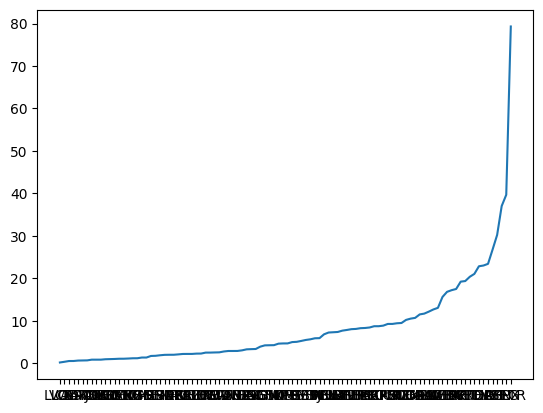

In [ ]:
#Normalise the differences with the maximum distance
wd = []
for i in range(len(tickers)):
    stock = ftse100Market.assets[i]
    #realSample = np.array(stocks[tickers[i]]["Price"].diff().dropna()[1:])
    realSample = calculateChange(stocks[ticker[i]], "percentage").to_numpy()[1:]

    wd.append([wasserstein_distance(u_values=stock.values, v_values=realSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(realSample))/len(realSample)), tickers[i]])

def distSort(e):
    return float(e[0])

wd.sort(key=distSort)
sTickers = []
sDistances = []
for item in wd:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.plot(sTickers, sDistances)
print(sTickers)
print(sDistances)

['LLOY', 'VOD', 'CNA', 'AAF', 'BT-A', 'TSCO', 'TW', 'CTEC', 'BARC', 'JD', 'NWG', 'HLN', 'SBRY', 'MNG', 'LGEN', 'RR', 'MKS', 'KGF', 'AV', 'SMDS', 'GLEN', 'HSBA', 'BME', 'SDR', 'BP', 'FCIT', 'PHNX', 'IAG', 'MRO', 'RTO', 'HWDN', 'BEZ', 'RMV', 'AUTO', 'BA', 'INF', 'BDEV', 'UU', 'STAN', 'SGE', 'LAND', 'FRAS', 'NG', 'RS1', 'PSON', 'SGRO', 'SMT', 'GSK', 'UTG', 'III', 'STJ', 'WPP', 'IMI', 'SSE', 'FRES', 'IMB', 'SMIN', 'SN', 'REL', 'MNDI', 'ANTO', 'BNZL', 'PSH', 'PRU', 'HLMA', 'WEIR', 'ENT', 'SHEL', 'CCH', 'BATS', 'BRBY', 'HIK', 'ADM', 'HL', 'CPG', 'ABF', 'SVT', 'EXPN', 'OCDO', 'DPLM', 'DGE', 'ULVR', 'AAL', 'SKG', 'EDV', 'WTB', 'ITRK', 'AHT', 'RKT', 'BKG', 'DPH', 'RIO', 'DCC', 'IHG', 'CRDA', 'NXT', 'AZN', 'LSEG', 'SPX', 'FLTR']
[0.12228330974807429, 0.24130028360836828, 0.325245896550744, 0.3478280931328508, 0.3965034619018417, 0.4076317527376612, 0.4386221073828928, 0.5060853949334629, 0.513527783063622, 0.5547332675079502, 0.5666797804434324, 0.5826472894199277, 0.6084421909605257, 0.62963496

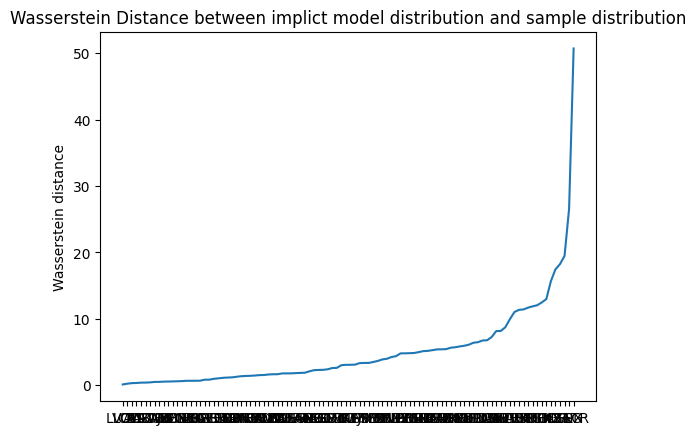

In [ ]:
wd = []
for i in range(len(tickers)):
    stock = ftse100_10jumpMarket.assets[i]
    realSample = calculateChange(stocks[ticker], "percentage").to_numpy()[1:]
    wd.append([wasserstein_distance(u_values=stock.values, v_values=realSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(realSample))/len(realSample)), tickers[i]])

#Sort by converting the first element into a float (and then ascending order)
def distSort(e):
    return float(e[0])

wd.sort(key=distSort)
sTickers = []
sDistances = []
for item in wd:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.title("Wasserstein Distance between implict model distribution and sample distribution")
plt.ylabel("Wasserstein distance")
plt.plot(sTickers, sDistances)
print(sTickers)
print(sDistances)

# Current limitations:
- We assume that we can model stock prices such that the increments are stationary.
- No cross vailidation or train/test split
- Quality of fit or statistical significance is missing.
- Comparing variances might be intersting, as well as the ability.
- Find the optimial clusters for clustering.

Todo
- Implement more accurate discrete model (i.e. difference varies dependent current price).
- Look at cross validation for current clustering results
+- Statistical tests - find if any significant, or most accurate models
